In [1]:
%load_ext autoreload
%autoreload 2

In [187]:
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [188]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [181]:
def create_lstm_data(X, y, k):
    '''
    input:
        data - the numpy matrix of (n, p+1) shape, where n is the number of rows,
               p+1 is the number of predictors + 1 target column
        k    - the length of the sequence, namely, the number of previous rows 
               (including current) we want to use to predict the target.
    output:
        X_data - the predictors numpy matrix of (n-k, k, p) shape
        y_data - the target numpy array of (n-k, 1) shape
    '''
    # initialize zero matrix of (n-k, k, p) shape to store the n-k number
    # of sequences of k-length and zero array of (n-k, 1) to store targets
    X_data = np.zeros([X.shape[0]-k, k, X.shape[1]])
    y_data = []
    
    # run loop to slice k-number of previous rows as 1 sequence to predict
    # 1 target and save them to X_data matrix and y_data list
    for i in range(k, X.shape[0]):
        cur_sequence = X[i-k: i, :]
        cur_target = y[i-1]
        
        X_data[i-k,:, :] = cur_sequence.reshape(1, k, X_data.shape[2])
        y_data.append(cur_target)
    
    return X_data, np.asarray(y_data)

In [182]:
def LSTM_model(X_train, y_train, X_valid, y_valid, k):
    # Define and compile LSTM model
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=(k, X_train.shape[2])))
    model.add(LSTM(50, return_sequences = False))
    #model.add(Dropout(0.2))
    #model.add(LSTM(50, return_sequences = True))
    #model.add(Dropout(0.2))
    #model.add(LSTM(50))
    #model.add(Dropout(0.2))
    model.add(Dense(1, "linear"))
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mse')#,  metrics=[''])
    # Early stopping and best model checkpoint parameters
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max', verbose=2, patience=5)
    mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', mode='min', verbose=2, save_best_only=True)
    # Train the model 
    history = model.fit(X_train, y_train,
                        validation_data=(X_valid, y_valid),
                        epochs=5, verbose=2, callbacks=[es, mc])

In [204]:
df = pd.read_csv("./data/preprocessed_data.csv")
df.describe()

,hydro,micro,thermal,wind,total,y,sys_reg,flow,y_prev,time_of_day,time_of_week,time_of_year
count,218476.000000,218476.000000,218476.000000,218476.000000,218476.000000,218476.000000,218476.000000,218476.000000,218476.000000,218476.000000,218476.000000,218476.000000
mean,1886.566494,224.103826,21.820337,55.677761,2188.169702,2.947032,-7.862550,-1997.643444,2.991219,11.540512,2.989834,5.233746
std,391.938330,57.853667,3.430808,46.851155,434.098625,293.817362,38.170766,1310.400513,294.217412,6.923604,1.991830,3.548513
min,714.533000,80.674000,4.500000,0.002000,903.810000,-887.243293,-512.000000,-5234.180000,-954.853235,0.000000,0.000000,0.000000
25%,1626.809000,185.014000,22.100000,15.892000,1918.362000,-141.735665,0.000000,-2998.660000,-141.742713,6.000000,1.000000,2.000000
50%,1930.184000,225.557000,22.100000,42.024000,2244.954000,-12.575697,0.000000,-1946.000000,-12.587640,12.000000,3.000000,5.000000
75%,2168.250000,268.708000,24.100000,88.319000,2490.977000,123.901878,0.000000,-905.400000,123.909845,18.000000,5.000000,8.000000
max,2901.979000,346.216000,25.600000,169.024000,3242.057000,2038.149064,120.000000,526.850000,2216.103712,23.000000,6.000000,11.000000


In [206]:
y = df.pop("y").values
categorical_columns = [("time_of_day", 24), ("time_of_week", 7), ("time_of_year", 12)]
X = []
for col, no_class in categorical_columns:
    print(col)
    print(df[col].shape)
    one_hot_encoded = tf.keras.utils.to_categorical(df[col], num_classes=no_class)
    df = df.drop(columns=[col])
    X.append(one_hot_encoded)

KeyError: 'y'

In [208]:

values = df.values
values = values.astype('float32')
scaled = values
#scaler = MinMaxScaler(feature_range=(-1, 1))
#scaled = scaler.fit_transform(values)

data_valid = scaled[int(df.shape[0]*0.8):,:]
y_valid = y[int(df.shape[0]*0.8):]
data_train = scaled[:int(df.shape[0]*0.8),:]
y_train = y[:int(df.shape[0]*0.8)]
#data_test = data_valid[int(data_valid.shape[0]*0.5):,:]
#data_valid = data_valid[:int(data_valid.shape[0]*0.5),:]

data_train.shape, data_valid.shape, data_test.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


ValueError: could not broadcast input array from shape (218476,24) into shape (218476)

In [183]:
seq_len = 10
 
X_train, y_train = create_lstm_data(data_train, y_train, seq_len)
X_valid, y_valid = create_lstm_data(data_valid, y_valid, seq_len)

LSTM_model(X_train, y_train, X_valid, y_valid, seq_len)


Epoch 1/5

Epoch 1: val_loss improved from inf to 23562.84375, saving model to best_model.h5
5462/5462 - 30s - loss: 56831.8711 - val_loss: 23562.8438 - 30s/epoch - 6ms/step
Epoch 2/5

Epoch 2: val_loss improved from 23562.84375 to 14630.76074, saving model to best_model.h5
5462/5462 - 27s - loss: 26649.0703 - val_loss: 14630.7607 - 27s/epoch - 5ms/step
Epoch 3/5

Epoch 3: val_loss improved from 14630.76074 to 10941.36621, saving model to best_model.h5
5462/5462 - 27s - loss: 15478.4463 - val_loss: 10941.3662 - 27s/epoch - 5ms/step
Epoch 4/5

Epoch 4: val_loss improved from 10941.36621 to 9614.29297, saving model to best_model.h5
5462/5462 - 27s - loss: 10966.8994 - val_loss: 9614.2930 - 27s/epoch - 5ms/step
Epoch 5/5

Epoch 5: val_loss improved from 9614.29297 to 9348.52539, saving model to best_model.h5
5462/5462 - 27s - loss: 8756.1797 - val_loss: 9348.5254 - 27s/epoch - 5ms/step


# Validate

In [190]:
df_val = pd.read_csv("./data/preprocessed_validation_data.csv")
df_val

,hydro,micro,thermal,wind,total,y,sys_reg,flow,y_prev,time_of_day_0,...,time_of_week_1,time_of_week_2,time_of_week_3,time_of_week_4,time_of_week_5,time_of_week_6,time_of_year_3,time_of_year_4,time_of_year_5,time_of_year_6
0,1942.490,191.881,20.1,106.431,2266.102,52.119595,0.0,-2252.90,NaN,0,...,0,0,0,0,0,0,1,0,0,0
1,1942.490,191.881,20.1,106.431,2266.102,90.374541,0.0,-2252.90,52.119595,0,...,0,0,0,0,0,0,1,0,0,0
2,1942.490,191.881,20.1,106.431,2266.102,88.435063,0.0,-2252.90,90.374541,0,...,0,0,0,0,0,0,1,0,0,0
3,1942.490,191.881,20.1,106.431,2266.102,53.375518,0.0,-2252.90,88.435063,0,...,0,0,0,0,0,0,1,0,0,0
4,1942.490,191.881,20.1,106.431,2266.102,65.496683,0.0,-2252.90,53.375518,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28131,2416.610,316.111,20.1,25.427,2778.248,-51.999568,-110.0,-135.00,-41.175585,0,...,0,0,0,0,0,1,0,0,0,1
28132,2416.610,316.111,20.1,25.427,2778.248,-55.399064,-110.0,-135.00,-51.999568,0,...,0,0,0,0,0,1,0,0,0,1
28133,2416.610,316.111,20.1,25.427,2778.248,-31.270359,-110.0,-138.42,-55.399064,0,...,0,0,0,0,0,1,0,0,0,1
28134,2350.079,316.121,20.1,32.935,2719.235,-54.007893,-110.0,-146.97,-31.270359,0,...,0,0,0,0,0,1,0,0,0,1


In [189]:
y = df_val.pop("y").values
values = df_val.values
values = values.astype('float32')
#values = scaler.transform(values)
print(values.shape)
X = values

KeyError: 'y'

In [158]:
print(X[start_ind:start_ind+seq_len])

[[-0.21739131 -1.         -0.6363637   0.3293457  -0.18379009  0.47867298
   0.7140018   0.38895178  0.6202532  -0.25253642 -0.5220267 ]
 [-0.21739131 -1.         -0.6363637   0.3293457  -0.18379009  0.47867298
   0.7140018   0.38895178  0.6202532  -0.25253642 -0.486629  ]
 [-0.21739131 -1.         -0.6363637   0.32934928 -0.18379009  0.47867298
   0.7140018   0.38895512  0.6202532  -0.25253642 -0.48923767]
 [-0.21739131 -1.         -0.6363637   0.32934928 -0.18379009  0.47867298
   0.7140018   0.38895512  0.6202532  -0.25253642 -0.4698853 ]
 [-0.21739131 -1.         -0.6363637   0.32934928 -0.18379009  0.47867298
   0.7140018   0.38895512  0.6202532  -0.25253642 -0.4603445 ]
 [-0.21739131 -1.         -0.6363637   0.32934928 -0.18379009  0.47867298
   0.7140018   0.38895512  0.6202532  -0.25253642 -0.4719755 ]
 [-0.21739131 -1.         -0.6363637   0.32934928 -0.18379009  0.47867298
   0.7140018   0.38895512  0.6202532  -0.25253642 -0.44398728]
 [-0.21739131 -1.         -0.6363637   0.

In [157]:
model = keras.models.load_model('best_model.h5')
forecast_window_len = 24
start_ind = 70
model_input = X[start_ind:start_ind+seq_len]
forecasts = [y[start_ind+seq_len-1]]
for pred_no in range(0, forecast_window_len):
    print("pred_no: ", model_input)
    forecast = model(np.array([model_input]))
    cp = np.zeros((seq_len, 11))
    cp[0:seq_len-2] = model_input[1:seq_len-1]
    cp[-1] = model_input[seq_len-1]
    cp[-1, -1] = forecast
    model_input = cp
    forecasts.append(forecast)

pred_no:  [[-0.21739131 -1.         -0.6363637   0.3293457  -0.18379009  0.47867298
   0.7140018   0.38895178  0.6202532  -0.25253642 -0.5220267 ]
 [-0.21739131 -1.         -0.6363637   0.3293457  -0.18379009  0.47867298
   0.7140018   0.38895178  0.6202532  -0.25253642 -0.486629  ]
 [-0.21739131 -1.         -0.6363637   0.32934928 -0.18379009  0.47867298
   0.7140018   0.38895512  0.6202532  -0.25253642 -0.48923767]
 [-0.21739131 -1.         -0.6363637   0.32934928 -0.18379009  0.47867298
   0.7140018   0.38895512  0.6202532  -0.25253642 -0.4698853 ]
 [-0.21739131 -1.         -0.6363637   0.32934928 -0.18379009  0.47867298
   0.7140018   0.38895512  0.6202532  -0.25253642 -0.4603445 ]
 [-0.21739131 -1.         -0.6363637   0.32934928 -0.18379009  0.47867298
   0.7140018   0.38895512  0.6202532  -0.25253642 -0.4719755 ]
 [-0.21739131 -1.         -0.6363637   0.32934928 -0.18379009  0.47867298
   0.7140018   0.38895512  0.6202532  -0.25253642 -0.44398728]
 [-0.21739131 -1.         -0.63

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


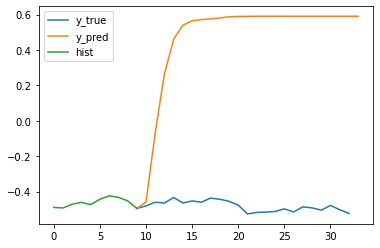

In [156]:

forecasts = np.array(forecasts)
forecasts = forecasts.reshape(forecast_window_len+1)

pyplot.plot(range(seq_len-1, seq_len+forecast_window_len-1), y[start_ind+seq_len-1:start_ind+seq_len+forecast_window_len-1], label='y_true')
pyplot.plot(range(seq_len-1, seq_len+forecast_window_len), forecasts, label='y_pred')
pyplot.plot(range(0, seq_len), y[start_ind:start_ind+seq_len], label='hist')

pyplot.legend()
pyplot.show()